In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import html, dcc, Input, Output
from sklearn.preprocessing import LabelEncoder
import gender_guesser.detector as gender
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Cargar datos
df = pd.read_excel('dataset/datos_campania.xlsx', header=0)

print("Vista inicial del DataFrame:")
display(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())
print("\nTipos de datos:")
print(df.dtypes)

Vista inicial del DataFrame:


,Unnamed: 0,Marca temporal,Dirección de correo electrónico,Seleccione la maestría de su interés,Nombres:,Apellidos:,Teléfono:,Ciudad:,Medio de contacto,Requeriemiento,Fecha,Asesor,Seguimiento 1,Fecha.1,Asesor.1,Seguimiento 2,Fecha.2,Asesor.2,Seguimiento 3,Estado
0,1,32-07-2025,NaN,Maestría en Derecho Constitucional con mención...,Lic.,Cedillo,593 99 951 2705,NaN,WhatsApp,Información General,NaT,Katherine Cabrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2025-08-02 00:00:00,NaN,Maestría en Derecho Constitucional con mención...,Carlos Gonzalo Alban,NaN,593 99 902 5450,NaN,WhatsApp,Información General,NaT,Katherine Cabrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2025-09-06 00:00:00,NaN,Maestría en Derecho Constitucional con mención...,Magali,NaN,593 98 406 7495,NaN,WhatsApp,Información General,NaT,Katherine Cabrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2025-09-23 00:00:00,NaN,Maestría en Derecho Constitucional con mención...,Richard Ayala,NaN,593 93 915 5733,NaN,WhatsApp,Información General,NaT,Katherine Cabrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2025,emanueljan110902@gmail.com,Maestría en Derecho Constitucional con mención...,JANDRY EMANUEL,RODRIGUEZ QUEVEDO,961452496,Loja,Graduados,Información General,2025-10-27,Johanna Mendoza,Se envía información vía Whatsapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columnas disponibles:
['Unnamed: 0', 'Marca temporal', 'Dirección de correo electrónico', 'Seleccione la maestría de su interés', 'Nombres:', 'Apellidos:', 'Teléfono:', 'Ciudad:', 'Medio de contacto', 'Requeriemiento ', 'Fecha', 'Asesor', 'Seguimiento 1', 'Fecha.1', 'Asesor.1', 'Seguimiento 2', 'Fecha.2', 'Asesor.2', 'Seguimiento 3', 'Estado ']

Tipos de datos:
Unnamed: 0                                       int64
Marca temporal                                  object
Dirección de correo electrónico                 object
Seleccione la maestría de su interés            object
Nombres:                                        object
Apellidos:                                      object
Teléfono:                                       object
Ciudad:                                         object
Medio de contacto                               object
Requeriemiento                                  object
Fecha                                   datetime64[ns]
Asesor                        

In [177]:
# =====================================
# 0. Detectar la columna de fecha-hora
# =====================================
posibles = ["marca temporal","Marca temporal"]

columna_marca = None
for col in df.columns:
    if any(key in col.lower() for key in posibles):
        columna_marca = col
        break

if columna_marca is None:
    raise ValueError("❌ No se encontró una columna de marca temporal en el DataFrame.")

print("➡️ Columna detectada:", columna_marca)


# =====================================
# 1. Función parse_marca
# =====================================
def parse_marca(valor):
    if pd.isna(valor):
        return pd.NaT

    valor_str = str(valor).strip()

    if re.match(r"\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}:\d{2}", valor_str):
        return pd.to_datetime(valor_str, format="%d/%m/%Y %H:%M:%S", errors="coerce")

    if re.match(r"\d{4}-\d{2}-\d{2}T", valor_str):
        return pd.to_datetime(valor_str, errors="coerce")

    if re.match(r"\d{1,2}/\d{1,2}/\d{4}$", valor_str):
        return pd.to_datetime(valor_str, format="%d/%m/%Y", errors="coerce")

    if re.match(r"\d{4}-\d{2}-\d{2}$", valor_str):
        return pd.to_datetime(valor_str, errors="coerce")

    return pd.to_datetime(valor_str, errors="coerce")


# Aplicar parser a la columna real
df["Marca temporal"] = df[columna_marca].apply(parse_marca)


# =====================================
# 2. Extraer hora con control de “desconocido”
# =====================================
def extraer_hora(valor):
    if pd.isna(valor):
        return "desconocido"

    original = str(valor)

    if valor.hour == 0 and "00:00:00" in original:
        return "desconocido"

    return valor.hour

df["hora"] = df["Marca temporal"].apply(extraer_hora)


➡️ Columna detectada: Marca temporal


In [178]:
print("\nNúmero de filas antes de eliminar duplicados:", len(df))

# Opción 1: Duplicados exactos en todas las columnas
duplicados_exactos = df.duplicated().sum()
print("Duplicados exactos (toda la fila idéntica):", duplicados_exactos)

# Opción 2 : duplicados por teléfono y/o correo
if 'Fecha' in df.columns:
    df = df.sort_values('Fecha')

# Elimina duplicados basados en Teléfono y Correo (si existen)
subset_dup = []
if 'Teléfono:' in df.columns:
    subset_dup.append('Teléfono:')
if 'Dirección de correo electrónico' in df.columns:
    subset_dup.append('Dirección de correo electrónico')

# NO se eliminan duplicados, solo se marcan
if subset_dup:
    df["es_duplicado"] = df.duplicated(subset=subset_dup, keep=False).astype(int)
    print("\nDuplicados detectados por Teléfono/Correo (NO eliminados):", df["es_duplicado"].sum())


print("Número de filas después de eliminar duplicados:", len(df))


Número de filas antes de eliminar duplicados: 238
Duplicados exactos (toda la fila idéntica): 0

Duplicados detectados por Teléfono/Correo (NO eliminados): 0
Número de filas después de eliminar duplicados: 238



Resumen de valores nulos por columna:
Unnamed: 0                                0
Marca temporal                            1
Dirección de correo electrónico           4
Seleccione la maestría de su interés     18
Nombres:                                  0
Apellidos:                               56
Teléfono:                                 0
Ciudad:                                   4
Medio de contacto                         1
Requeriemiento                            0
Fecha                                     4
Asesor                                    0
Seguimiento 1                             4
Fecha.1                                 238
Asesor.1                                238
Seguimiento 2                           238
Fecha.2                                 238
Asesor.2                                238
Seguimiento 3                           238
Estado                                  237
hora                                      0
es_duplicado                         

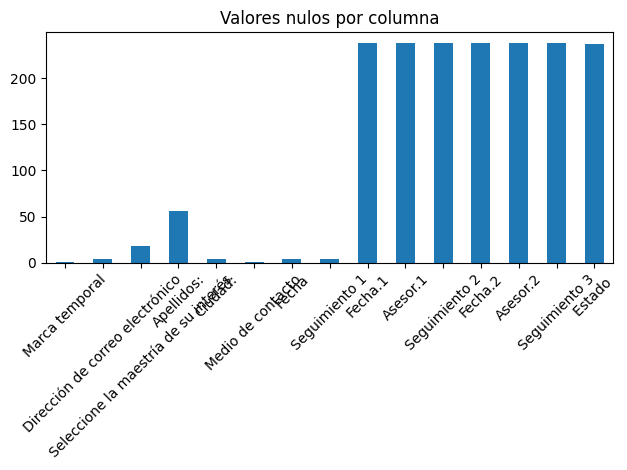


Registros sin teléfono ni correo: 0

Valores únicos después de rellenar 'DESCONOCIDO':

Columna: Ciudad:
Ciudad:
Loja         166
Quito         15
Guayaquil      5
Ambato         4
nan            4
Name: count, dtype: int64

Columna: Medio de contacto
Medio de contacto
Graduados         90
Expo-graduados    53
fb                51
Página Web        26
Pagina web        10
Name: count, dtype: int64

Columna: Seleccione la maestría de su interés
Seleccione la maestría de su interés
Maestría en Derecho Constitucional con mención en Derechos Humanos    220
nan                                                                    18
Name: count, dtype: int64


In [179]:
# ============================================================
# 2.1 ANÁLISIS Y TRATAMIENTO DE VALORES NULOS
#    Criterio: conservar registros útiles para segmentación
# ============================================================

print("\nResumen de valores nulos por columna:")
nulos = df.isna().sum()
print(nulos)

# Visualización rápida de columnas con nulos
plt.figure()
nulos_filtrados = nulos[nulos > 0]
if len(nulos_filtrados) > 0:
    nulos_filtrados.plot(kind='bar')
    plt.title('Valores nulos por columna')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron valores nulos en el DataFrame.")

# --- 2.1 Manejo de registros sin información de contacto (teléfono y correo) ----


if 'Teléfono:' in df.columns and 'Dirección de correo electrónico' in df.columns:
    df['sin_contacto'] = df['Teléfono:'].isna() & df['Dirección de correo electrónico'].isna()
    print("\nRegistros sin teléfono ni correo:", df['sin_contacto'].sum())
    
    # Si quieres eliminarlos:
    df = df[~df['sin_contacto']].drop(columns=['sin_contacto'])

# --- 2.2 Relleno de nulos en variables categóricas (ciudad, medio, estado, requerimiento) ----

cols_cat = []
for col in ['Ciudad:', 
            'Medio de contacto', 
            'Estado', 
            'Requeriemiento',
            'Seleccione la maestría de su interés']:
    if col in df.columns:
        cols_cat.append(col)

for c in cols_cat:
    df[c] = df[c].astype(str)
    df[c] = df[c].str.strip()          # quitar espacios
    df[c] = df[c].replace('', np.nan)  # convertir vacío a NaN
    df[c] = df[c].fillna('DESCONOCIDO')

print("\nValores únicos después de rellenar 'DESCONOCIDO':")
for c in cols_cat:
    print(f"\nColumna: {c}")
    print(df[c].value_counts().head())

# --- 2.3 Manejo especial de teléfono limpio ----
if 'Teléfono_limpio' in df.columns:
    df['telefono_valido'] = df['Teléfono_limpio'].notna().astype(int)
    df['estado_telefono'] = np.where(df['Teléfono_limpio'].notna(),
                                     'TELEFONO_VALIDO',
                                     'TELEFONO_DESCONOCIDO')
    print("\nConteo de estado_telefono:")
    print(df['estado_telefono'].value_counts())


In [180]:
# ============================================================
# 3. ELIMINACIÓN DE COLUMNAS POCO RELEVANTES O MUY VACÍAS
#    
# ============================================================

cols_a_eliminar = []
for col in ['Fecha.1', 'Asesor.1', 'Seguimiento 2', 'Fecha.2',
            'Asesor.2', 'Seguimiento 3', 'Marca temporal', 'Unnamed: 0']:
    if col in df.columns:
        cols_a_eliminar.append(col)

print("\nColumnas a eliminar por baja relevancia o alta cantidad de nulos:", cols_a_eliminar)

df = df.drop(columns=cols_a_eliminar, errors='ignore')

print("\nColumnas después de eliminación:")
print(df.columns.tolist())


Columnas a eliminar por baja relevancia o alta cantidad de nulos: ['Fecha.1', 'Asesor.1', 'Seguimiento 2', 'Fecha.2', 'Asesor.2', 'Seguimiento 3', 'Marca temporal', 'Unnamed: 0']

Columnas después de eliminación:
['Dirección de correo electrónico', 'Seleccione la maestría de su interés', 'Nombres:', 'Apellidos:', 'Teléfono:', 'Ciudad:', 'Medio de contacto', 'Requeriemiento ', 'Fecha', 'Asesor', 'Seguimiento 1', 'Estado ', 'hora', 'es_duplicado']


In [181]:
# ============================================================
# 4. ESTANDARIZACIÓN Y LIMPIEZA DE TEXTO
#    Criterio: evitar categorías duplicadas por formato
# ============================================================

# Lista de columnas de texto relevantes para segmentación
cols_texto = []
for col in ['Nombres:', 'Apellidos:', 'Ciudad:',
            'Medio de contacto', 'Seleccione la maestría de su interés',
            'Estado', 'Requeriemiento']:
    if col in df.columns:
        cols_texto.append(col)

# 🔹 Agregamos también correo y teléfono a las columnas de texto
for col in ['Dirección de correo electrónico', 'Teléfono:']:
    if col in df.columns and col not in cols_texto:
        cols_texto.append(col)

for c in cols_texto:
    # Convertimos a string, quitamos espacios y pasamos a mayúsculas
    df[c] = (df[c]
             .astype(str)
             .str.strip()
             .str.upper()
             .replace('NAN', np.nan)  # por si algún NaN se convirtió en texto "NAN"
            )

# 4.2 Rellenar vacíos y NaN con DESCONOCIDO en columnas clave
cols_rellenar = [
    'Seleccione la maestría de su interés',
    'Dirección de correo electrónico',
    'Estado',
    'Teléfono:',
    'Ciudad:', 
    'Fecha',
    'anio',
    'mes',
    'dia',
    'dia_semana',
    'mes_nombre',
    'Medio de contacto',
    'Seguimiento 1'
]

for col in cols_rellenar:
    if col in df.columns:
        df[col] = df[col].replace('', np.nan)        # vacíos explícitos a NaN
        df[col] = df[col].fillna('DESCONOCIDO')      # NaN -> DESCONOCIDO
        df[col] = df[col].astype(str).str.upper()    # aseguramos mayúsculas

print("\nVista rápida de algunas columnas de texto estandarizadas:")
for c in cols_texto:
    print(f"\nColumna: {c}")
    print(df[c].value_counts().head())

# 4.3 Normalización de abreviaturas en 'Medio de contacto'
if 'Medio de contacto' in df.columns:
    # Aseguramos mayúsculas
    df['Medio de contacto'] = df['Medio de contacto'].str.upper()
    
    # Reemplazo de abreviaturas por nombres completos
    df['Medio de contacto'] = df['Medio de contacto'].replace({
        'FB': 'FACEBOOK',
        'IG': 'INSTAGRAM',
        'WA': 'WHATSAPP',
        'IN': 'LINKEDIN',
        'PAGINA WEB' : 'PÁGINA WEB',
        'QUITÓ': 'QUITO',
        'PORTOVIEJO,': 'PORTOVIEJO'
    })

print("\nValores únicos normalizados en 'Medio de contacto':")
print(df['Medio de contacto'].value_counts())

if 'Dirección de correo electrónico' in df.columns:
    df['Dirección de correo electrónico'] = (
        df['Dirección de correo electrónico']
        .astype(str)
        .str.strip()
        .str.lower()            # correo SIEMPRE en minúsculas
    )

    # Convertir "DESCONOCIDO", "NAN", espacio vacío → "desconocido"
    df['Dirección de correo electrónico'] = (
        df['Dirección de correo electrónico']
        .replace(['nan', 'NaN', 'NAN', '', ' '], 'desconocido')
    )


def limpiar_ciudad(ciudad):
    """
    Limpieza exhaustiva de la columna Ciudad ANTES de clasificación
    - Elimina comas, puntos, signos de puntuación
    - Elimina espacios extra
    - Normaliza caracteres especiales
    """
    if pd.isna(ciudad) or ciudad == '':
        return 'DESCONOCIDO'
    
    ciudad = str(ciudad).strip().upper()
    
    # Eliminar TODOS los signos de puntuación
    signos_a_eliminar = [',', '.', ';', ':', '!', '?', '"', "'", '(', ')', '[', ']', '{', '}']
    for signo in signos_a_eliminar:
        ciudad = ciudad.replace(signo, '')
    
    # Reemplazar guiones y barras por espacios
    ciudad = ciudad.replace('-', ' ').replace('_', ' ').replace('/', ' ')
    
    # Eliminar espacios múltiples y trim
    ciudad = ' '.join(ciudad.split())
    
    # Si quedó vacío después de la limpieza
    if ciudad == '':
        return 'DESCONOCIDO'
    
    return ciudad

# Aplicar limpieza previa a la columna Ciudad
if 'Ciudad:' in df.columns:
    print("\n" + "="*80)
    print("LIMPIEZA PREVIA DE COLUMNA CIUDAD")
    print("="*80)
    
    # Mostrar ejemplos ANTES de la limpieza
    print("\nEjemplos ANTES de limpieza:")
    ciudades_con_comas = df[df['Ciudad:'].astype(str).str.contains(',', na=False)]['Ciudad:'].unique()[:10]
    if len(ciudades_con_comas) > 0:
        for ciudad in ciudades_con_comas:
            print(f"  - '{ciudad}'")
    
    # Aplicar limpieza
    df['Ciudad:'] = df['Ciudad:'].apply(limpiar_ciudad)
    
    # Mostrar ejemplos DESPUÉS de la limpieza
    print("\nEjemplos DESPUÉS de limpieza:")
    print(df['Ciudad:'].value_counts().head(15))
    
    print("\n✓ Limpieza de columna Ciudad completada")



Vista rápida de algunas columnas de texto estandarizadas:

Columna: Nombres:
Nombres:
DAVID ALEJANDRO      2
MANUEL               2
JENIFFER NICOLE      1
JANDRY EMANUEL       1
LOURDES ELIZABETH    1
Name: count, dtype: int64

Columna: Apellidos:
Apellidos:
SARANGO              2
VARGAS ESPINOSA      1
PARDO VEGA           1
AYALA GUTIERREZ      1
RODRIGUEZ QUEVEDO    1
Name: count, dtype: int64

Columna: Ciudad:
Ciudad:
LOJA           169
QUITO           16
AMBATO           5
GUAYAQUIL        5
DESCONOCIDO      4
Name: count, dtype: int64

Columna: Medio de contacto
Medio de contacto
GRADUADOS         90
EXPO-GRADUADOS    53
FB                51
PÁGINA WEB        26
PAGINA WEB        10
Name: count, dtype: int64

Columna: Seleccione la maestría de su interés
Seleccione la maestría de su interés
MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN EN DERECHOS HUMANOS    220
DESCONOCIDO                                                            18
Name: count, dtype: int64

Columna: Direcci

In [182]:
# ============================================================
# 4.X INFERENCIA DE GÉNERO A PARTIR DE NOMBRES
#    
# ============================================================
import unicodedata

# ------------------------------------------------------------
# Normalización y obtención del primer nombre
# ------------------------------------------------------------
def normalizar_texto_basico(s):
    """
    Pasa a mayúsculas, quita tildes y caracteres raros.
    """
    if pd.isna(s):
        return ""
    s = str(s).strip().upper()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

def obtener_primer_nombre_crudo(nombre_completo):
    """
    - Normaliza el texto
    - Elimina prefijos tipo LIC, DR, ING (si existieran)
    - Devuelve el primer token que parezca nombre
    """
    if pd.isna(nombre_completo):
        return ""
    
    s = normalizar_texto_basico(nombre_completo)

    if s == "" or s in ["DESCONOCIDO"]:
        return ""

    prefijos = ["LIC.", "LIC", "DR.", "DR", "ING.", "ING", 
                "SR.", "SR", "SRA.", "SRA", "MG.", "MGS."]
    tokens = s.replace(",", " ").replace("  ", " ").split()

    tokens_filtrados = []
    for t in tokens:
        if t in prefijos:
            continue
        if t in ["NINGUNO", "NINGUNA"]:
            continue
        if len(t) == 1:
            continue
        tokens_filtrados.append(t)

    if not tokens_filtrados:
        return ""

    return tokens_filtrados[0]

# ------------------------------------------------------------
# Diccionarios dinámicos (aprendizaje en memoria)
# (inician vacíos, se van llenando con lo que se vaya infiriendo)
# ------------------------------------------------------------
NOMBRES_FEMENINOS = set()
NOMBRES_MASCULINOS = set()

# ------------------------------------------------------------
# Inicializar gender_guesser una sola vez
# ------------------------------------------------------------
detector_genero = gender.Detector(case_sensitive=False)

def inferir_genero_combined(nombre_completo):
    """
    Orden de decisión:
    1) Normalizar y obtener primer nombre.
    2) Revisar diccionarios dinámicos (nombres ya aprendidos).
    3) Probar con gender_guesser.
    4) Si sigue indeciso, usar reglas heurísticas por terminación.
    5) Si una regla decide, APRENDER el nombre (guardar en set).
    """
    primer_nombre = obtener_primer_nombre_crudo(nombre_completo)

    if primer_nombre == "":
        return "DESCONOCIDO"

    # 1) Ya conocido por diccionarios dinámicos
    if primer_nombre in NOMBRES_FEMENINOS:
        return "MUJER"
    if primer_nombre in NOMBRES_MASCULINOS:
        return "HOMBRE"

    # 2) Probar con gender_guesser
    resultado = detector_genero.get_gender(primer_nombre)
    mapeo = {
        'male': 'HOMBRE',
        'mostly_male': 'HOMBRE',
        'female': 'MUJER',
        'mostly_female': 'MUJER',
        'andy': 'DESCONOCIDO',   # andrógino
        'unknown': 'DESCONOCIDO'
    }
    genero_gg = mapeo.get(resultado, 'DESCONOCIDO')

    # Si gender_guesser es claro, usamos y aprendemos
    if genero_gg == "HOMBRE":
        NOMBRES_MASCULINOS.add(primer_nombre)
        return "HOMBRE"
    if genero_gg == "MUJER":
        NOMBRES_FEMENINOS.add(primer_nombre)
        return "MUJER"

    # 3) Si sigue desconocido -> reglas heurísticas + aprendizaje
    ultima = primer_nombre[-1]

    # Terminación femenina clásica
    if ultima == "A":
        NOMBRES_FEMENINOS.add(primer_nombre)
        return "MUJER"

    # Terminación masculina clásica
    if ultima == "O":
        NOMBRES_MASCULINOS.add(primer_nombre)
        return "HOMBRE"

    # Terminaciones I / Y -> femenina (ej: NANCY, WENDY)
    if ultima in ["I", "Y"]:
        NOMBRES_FEMENINOS.add(primer_nombre)
        return "MUJER"

    # Terminaciones típicas masculinas: EL, ER, AN, EN
    if primer_nombre.endswith(("EL", "ER", "AN", "EN")):
        NOMBRES_MASCULINOS.add(primer_nombre)
        return "HOMBRE"

    # 4) Si nada funcionó
    return "DESCONOCIDO"

# ------------------------------------------------------------
# Aplicar al DataFrame
# ------------------------------------------------------------
if 'Nombres:' in df.columns:
    print("\nInfiriendo género de nombres (gender-guesser + reglas + aprendizaje dinámico)...")
    df['GENERO'] = df['Nombres:'].apply(inferir_genero_combined)
else:
    df['GENERO'] = "DESCONOCIDO"

print("\n" + "="*80)
print("DISTRIBUCIÓN DE GÉNERO INFERIDA (MÉTODO COMBINADO AUTOMÁTICO)")
print("="*80)
print(df['GENERO'].value_counts())
print(f"\nTotal de registros: {len(df)}")
print(f"Porcentaje de identificación exitosa: {(df['GENERO'] != 'DESCONOCIDO').sum() / len(df) * 100:.1f}%")



Infiriendo género de nombres (gender-guesser + reglas + aprendizaje dinámico)...

DISTRIBUCIÓN DE GÉNERO INFERIDA (MÉTODO COMBINADO AUTOMÁTICO)
GENERO
HOMBRE         131
MUJER           87
DESCONOCIDO     20
Name: count, dtype: int64

Total de registros: 238
Porcentaje de identificación exitosa: 91.6%


In [183]:
# ============================================================
# 4.2 NORMALIZACIÓN Y CLASIFICACIÓN GEOGRÁFICA COMPLETA
# ============================================================

# 4.1 Diccionario de clasificación geográfica de Ecuador (AMPLIADO)
clasificacion_geografica = {
    # PAÍSES
    'PAISES': {
        'COLOMBIA', 'PERU', 'PERÚ', 'ESPAÑA', 'VENEZUELA', 'ARGENTINA', 
        'CHILE', 'MEXICO', 'MÉXICO', 'USA', 'ESTADOS UNIDOS', 'BRASIL',
        'BOLIVIA', 'PARAGUAY', 'URUGUAY','ECUADOR'
    },
    
    # PRINCIPALES CIUDADES DE ECUADOR (todas las capitales provinciales + ciudades importantes)
    'CIUDADES': {
        'LOJA': ['LOJA', 'CIUDAD DE LOJA'],
        'QUITO': ['QUITO', 'SAN FRANCISCO DE QUITO'],
        'GUAYAQUIL': ['GUAYAQUIL', 'SANTIAGO DE GUAYAQUIL'],
        'CUENCA': ['CUENCA', 'SANTA ANA DE LOS RIOS DE CUENCA'],
        'AMBATO': ['AMBATO'],
        'MANTA': ['MANTA'],
        'MACHALA': ['MACHALA'],
        'IBARRA': ['IBARRA', 'SAN MIGUEL DE IBARRA'],
        'PORTOVIEJO': ['PORTOVIEJO'],
        'RIOBAMBA': ['RIOBAMBA'],
        'ESMERALDAS': ['ESMERALDAS'],
        'TULCAN': ['TULCAN', 'TULCÁN'],
        'BABAHOYO': ['BABAHOYO'],
        'LATACUNGA': ['LATACUNGA'],
        'SANTO DOMINGO': ['SANTO DOMINGO', 'SANTO DOMINGO DE LOS TSACHILAS'],
        'PUYO': ['PUYO'],
        'TENA': ['TENA'],
        'NUEVA LOJA': ['NUEVA LOJA', 'LAGO AGRIO'],
        'ZAMORA': ['ZAMORA'],
        'SALINAS': ['SALINAS'],
        'OTAVALO': ['OTAVALO'],
        'NARANJITO': ['NARANJITO'],
        'MILAGRO': ['MILAGRO'],
        'DURAN': ['DURAN', 'DURÁN'],
        'DAULE': ['DAULE'],
        'QUEVEDO': ['QUEVEDO'],
        'SANTA ELENA': ['SANTA ELENA'],
        'LA LIBERTAD': ['LA LIBERTAD']
    },
    
    # CANTONES POR PROVINCIA
    'CANTONES': {
        # PROVINCIA DE LOJA
        'CATAMAYO': ['CATAMAYO'],
        'CARIAMANGA': ['CARIAMANGA'],
        'CATACOCHA': ['CATACOCHA'],
        'MACARÁ': ['MACARA', 'MACARÁ'],
        'CELICA': ['CELICA'],
        'PINDAL': ['PINDAL'],
        'ZAPOTILLO': ['ZAPOTILLO'],
        'PUYANGO': ['PUYANGO'],
        'ALAMOR': ['ALAMOR'],
        'GONZANAMÁ': ['GONZANAMA', 'GONZANAMÁ'],
        'QUILANGA': ['QUILANGA'],
        'CALVAS': ['CALVAS'],
        'ESPÍNDOLA': ['ESPINDOLA', 'ESPÍNDOLA'],
        'SOZORANGA': ['SOZORANGA'],
        'CHAGUARPAMBA': ['CHAGUARPAMBA'],
        'OLMEDO': ['OLMEDO'],
        'PALTAS': ['PALTAS'],
        'SARAGURO': ['SARAGURO'],
        
        # PROVINCIA DE ZAMORA CHINCHIPE
        'EL PANGUI': ['EL PANGUI', 'PANGUI'],
        'YANTZAZA': ['YANTZAZA', 'YANZATZA'],
        'CENTINELA DEL CÓNDOR': ['CENTINELA DEL CONDOR', 'CENTINELA DEL CÓNDOR'],
        'CHINCHIPE': ['CHINCHIPE'],
        'NANGARITZA': ['NANGARITZA'],
        'PALANDA': ['PALANDA'],
        'PAQUISHA': ['PAQUISHA'],
        
        # PROVINCIA DE EL ORO
        'ZARUMA': ['ZARUMA'],
        'PIÑAS': ['PINAS', 'PIÑAS'],
        'PORTOVELO': ['PORTOVELO'],
        'ARENILLAS': ['ARENILLAS'],
        'HUAQUILLAS': ['HUAQUILLAS'],
        'PASAJE': ['PASAJE'],
        'SANTA ROSA': ['SANTA ROSA'],
        'EL GUABO': ['EL GUABO', 'GUABO'],
        'BALSAS': ['BALSAS'],
        'CHILLA': ['CHILLA'],
        'MARCABELÍ': ['MARCABELI', 'MARCABELÍ'],
        'ATAHUALPA': ['ATAHUALPA'],
        'LAS LAJAS': ['LAS LAJAS'],
        
        # PROVINCIA DE AZUAY
        'GUALACEO': ['GUALACEO'],
        'PAUTE': ['PAUTE'],
        'SIGSIG': ['SIGSIG'],
        'SANTA ISABEL': ['SANTA ISABEL'],
        'NABÓN': ['NABON', 'NABÓN'],
        'OÑA': ['ONA', 'OÑA'],
        'GIRÓN': ['GIRON', 'GIRÓN'],
        'PUCARÁ': ['PUCARA', 'PUCARÁ'],
        'SAN FERNANDO': ['SAN FERNANDO'],
        'CHORDELEG': ['CHORDELEG'],
        'EL PAN': ['EL PAN'],
        'SEVILLA DE ORO': ['SEVILLA DE ORO'],
        'GUACHAPALA': ['GUACHAPALA'],
        'CAMILO PONCE ENRÍQUEZ': ['CAMILO PONCE ENRIQUEZ', 'CAMILO PONCE ENRÍQUEZ'],
        
        # PROVINCIA DE PICHINCHA
        'CAYAMBE': ['CAYAMBE'],
        'MEJÍA': ['MEJIA', 'MEJÍA'],
        'PEDRO MONCAYO': ['PEDRO MONCAYO'],
        'RUMIÑAHUI': ['RUMINAHUI', 'RUMIÑAHUI'],
        'SAN MIGUEL DE LOS BANCOS': ['SAN MIGUEL DE LOS BANCOS'],
        'PEDRO VICENTE MALDONADO': ['PEDRO VICENTE MALDONADO'],
        'PUERTO QUITO': ['PUERTO QUITO'],
        
        # PROVINCIA DE TUNGURAHUA
        'BAÑOS': ['BANOS', 'BAÑOS', 'BANOS DE AGUA SANTA'],
        'CEVALLOS': ['CEVALLOS'],
        'MOCHA': ['MOCHA'],
        'PATATE': ['PATATE'],
        'PELILEO': ['PELILEO'],
        'PÍLLARO': ['PILLARO', 'PÍLLARO'],
        'QUERO': ['QUERO'],
        'TISALEO': ['TISALEO'],
        
        # PROVINCIA DE IMBABURA
        'COTACACHI': ['COTACACHI'],
        'ANTONIO ANTE': ['ANTONIO ANTE'],
        'PIMAMPIRO': ['PIMAMPIRO'],
        'URCUQUÍ': ['URCUQUI', 'URCUQUÍ'],
        
        # PROVINCIA DE CAÑAR
        'AZOGUES': ['AZOGUES'],
        'BIBLIÁN': ['BIBLIAN', 'BIBLIÁN'],
        'CAÑAR': ['CANAR', 'CAÑAR'],
        'LA TRONCAL': ['LA TRONCAL'],
        'DELEG': ['DELEG'],
        'SUSCAL': ['SUSCAL'],
        'EL TAMBO': ['EL TAMBO'],
        
        # PROVINCIA DE MANABÍ
        'JIPIJAPA': ['JIPIJAPA'],
        'MONTECRISTI': ['MONTECRISTI'],
        'CHONE': ['CHONE'],
        'EL CARMEN': ['EL CARMEN'],
        'PEDERNALES': ['PEDERNALES'],
        'BAHÍA DE CARÁQUEZ': ['BAHIA DE CARAQUEZ', 'BAHÍA DE CARÁQUEZ', 'BAHIA'],
        'CALCETA': ['CALCETA'],
        'TOSAGUA': ['TOSAGUA'],
        'SUCRE': ['SUCRE'],
        'ROCAFUERTE': ['ROCAFUERTE'],
        
        # PROVINCIA DE LOS RÍOS
        'VENTANAS': ['VENTANAS'],
        'VINCES': ['VINCES'],
        'BABA': ['BABA'],
        'MONTALVO': ['MONTALVO'],
        'PALENQUE': ['PALENQUE'],
        'PUEBLO VIEJO': ['PUEBLO VIEJO'],
        'URDANETA': ['URDANETA'],
        'BUENA FE': ['BUENA FE'],
        'VALENCIA': ['VALENCIA'],
        'MOCACHE': ['MOCACHE'],
        
        # PROVINCIA DE GUAYAS
        'ALFREDO BAQUERIZO MORENO': ['ALFREDO BAQUERIZO MORENO'],
        'BALAO': ['BALAO'],
        'BALZAR': ['BALZAR'],
        'COLIMES': ['COLIMES'],
        'CORONEL MARCELINO MARIDUEÑA': ['CORONEL MARCELINO MARIDUENA'],
        'EL EMPALME': ['EL EMPALME', 'EMPALME'],
        'EL TRIUNFO': ['EL TRIUNFO'],
        'GENERAL ANTONIO ELIZALDE': ['GENERAL ANTONIO ELIZALDE'],
        'ISIDRO AYORA': ['ISIDRO AYORA'],
        'LOMAS DE SARGENTILLO': ['LOMAS DE SARGENTILLO'],
        'MARCELINO MARIDUEÑA': ['MARCELINO MARIDUENA'],
        'NARANJAL': ['NARANJAL'],
        'NOBOL': ['NOBOL'],
        'PALESTINA': ['PALESTINA'],
        'PEDRO CARBO': ['PEDRO CARBO'],
        'PLAYAS': ['PLAYAS'],
        'SALITRE': ['SALITRE'],
        'SAMBORONDÓN': ['SAMBORONDON', 'SAMBORONDÓN'],
        'SANTA LUCÍA': ['SANTA LUCIA', 'SANTA LUCÍA'],
        'SIMÓN BOLÍVAR': ['SIMON BOLIVAR', 'SIMÓN BOLÍVAR'],
        'YAGUACHI': ['YAGUACHI'],
        
        # PROVINCIA DE CHIMBORAZO
        'ALAUSÍ': ['ALAUSI', 'ALAUSÍ'],
        'COLTA': ['COLTA'],
        'CHAMBO': ['CHAMBO'],
        'CHUNCHI': ['CHUNCHI'],
        'GUAMOTE': ['GUAMOTE'],
        'GUANO': ['GUANO'],
        'PALLATANGA': ['PALLATANGA'],
        'PENIPE': ['PENIPE'],
        'CUMANDÁ': ['CUMANDA', 'CUMANDÁ'],
        
        # PROVINCIA DE COTOPAXI
        'LATACUNGA': ['LATACUNGA'],
        'LA MANÁ': ['LA MANA', 'LA MANÁ'],
        'PANGUA': ['PANGUA'],
        'PUJILÍ': ['PUJILI', 'PUJILÍ'],
        'SALCEDO': ['SALCEDO'],
        'SAQUISILÍ': ['SAQUISILI', 'SAQUISILÍ'],
        'SIGCHOS': ['SIGCHOS'],
        'EL CORAZON' : ['PANGUA'],
        
        # PROVINCIA DE MORONA SANTIAGO
        'GUALAQUIZA': ['GUALAQUIZA'],
        'LIMÓN INDANZA': ['LIMON INDANZA', 'LIMÓN INDANZA'],
        'PALORA': ['PALORA'],
        'SANTIAGO': ['SANTIAGO'],
        'SUCÚA': ['SUCUA', 'SUCÚA'],
        'HUAMBOYA': ['HUAMBOYA'],
        'SAN JUAN BOSCO': ['SAN JUAN BOSCO'],
        'TAISHA': ['TAISHA'],
        'LOGROÑO': ['LOGRONO', 'LOGROÑO'],
        'PABLO SEXTO': ['PABLO SEXTO'],
        'TIWINTZA': ['TIWINTZA'],
        
        # PROVINCIA DE PASTAZA
        'MERA': ['MERA'],
        'SANTA CLARA': ['SANTA CLARA'],
        'ARAJUNO': ['ARAJUNO'],
        
        # PROVINCIA DE NAPO
        'ARCHIDONA': ['ARCHIDONA'],
        'EL CHACO': ['EL CHACO'],
        'QUIJOS': ['QUIJOS'],
        'CARLOS JULIO AROSEMENA TOLA': ['CARLOS JULIO AROSEMENA TOLA'],
        
        # PROVINCIA DE ORELLANA
        'FRANCISCO DE ORELLANA': ['FRANCISCO DE ORELLANA'],
        'AGUARICO': ['AGUARICO'],
        'LA JOYA DE LOS SACHAS': ['LA JOYA DE LOS SACHAS'],
        'LORETO': ['LORETO'],
        
        # PROVINCIA DE SUCUMBÍOS
        'GONZALO PIZARRO': ['GONZALO PIZARRO'],
        'PUTUMAYO': ['PUTUMAYO'],
        'SHUSHUFINDI': ['SHUSHUFINDI'],
        'SUCUMBÍOS': ['SUCUMBIOS', 'SUCUMBÍOS'],
        'CASCALES': ['CASCALES'],
        'CUYABENO': ['CUYABENO'],
        
        # PROVINCIA DE CARCHI
        'MONTÚFAR': ['MONTUFAR', 'MONTÚFAR'],
        'BOLÍVAR': ['BOLIVAR', 'BOLÍVAR'],
        'ESPEJO': ['ESPEJO'],
        'MIRA': ['MIRA'],
        'SAN PEDRO DE HUACA': ['SAN PEDRO DE HUACA'],
        
        # PROVINCIA DE ESMERALDAS
        'ATACAMES': ['ATACAMES'],
        'ELOY ALFARO': ['ELOY ALFARO'],
        'MUISNE': ['MUISNE'],
        'QUININDÉ': ['QUININDE', 'QUININDÉ'],
        'SAN LORENZO': ['SAN LORENZO'],
        'RIOVERDE': ['RIOVERDE'],
        
        # PROVINCIA DE SANTA ELENA
        'SANTA ELENA': ['SANTA ELENA'],
        'LA LIBERTAD': ['LA LIBERTAD'],
        
        # PROVINCIA DE GALÁPAGOS
        'SAN CRISTÓBAL': ['SAN CRISTOBAL', 'SAN CRISTÓBAL'],
        'ISABELA': ['ISABELA'],
        'SANTA CRUZ': ['SANTA CRUZ']
    },
    
    # PARROQUIAS IMPORTANTES (principalmente de Loja y ciudades grandes)
    'PARROQUIAS': {
        # Parroquias urbanas de Loja ciudad
        'EL VALLE': ['EL VALLE', 'VALLE'],
        'SUCRE': ['SUCRE'],
        'SAN SEBASTIÁN': ['SAN SEBASTIAN', 'SAN SEBASTIÁN'],
        'EL SAGRARIO': ['EL SAGRARIO', 'SAGRARIO'],
        
        # Parroquias rurales de Loja
        'MALACATOS': ['MALACATOS'],
        'VILCABAMBA': ['VILCABAMBA'],
        'YANGANA': ['YANGANA'],
        'QUINARA': ['QUINARA'],
        'SAN LUCAS': ['SAN LUCAS'],
        'SANTIAGO': ['SANTIAGO'],
        'CHANTACO': ['CHANTACO'],
        'CHUQUIRIBAMBA': ['CHUQUIRIBAMBA'],
        'EL CISNE': ['EL CISNE', 'CISNE'],
        'GUALEL': ['GUALEL'],
        'JIMBILLA': ['JIMBILLA'],
        'TAQUIL': ['TAQUIL'],
        'SAN PEDRO DE LA BENDITA': ['SAN PEDRO DE LA BENDITA', 'LA BENDITA'],
        
        # Parroquias de Catamayo
        'LA TOMA': ['LA TOMA'],
        'EL TAMBO': ['EL TAMBO', 'TAMBO'],
        'ZAMBI': ['ZAMBI', 'ZUMBI'],
        'GUAYQUICHUMA': ['GUAYQUICHUMA'],
        
        # Parroquias de otros cantones de Loja
        'CARIGÁN': ['CARIGAN', 'CARIGÁN'],
        'NAMBACOLA': ['NAMBACOLA'],
        'CHUQUIRIBAMBA': ['CHUQUIRIBAMBA'],
        'EL LUCERO': ['EL LUCERO'],
        'LARAMA': ['LARAMA'],
        'SABIANGO': ['SABIANGO'],
        'UTUANA': ['UTUANA'],
        'SAN PABLO DE TENTA': ['SAN PABLO DE TENTA', 'SAN PABLO'],
        'EL AIRO': ['EL AIRO'],
        'EL INGENIO': ['EL INGENIO'],
        'JIMBURA': ['JIMBURA'],
        'COLAISACA': ['COLAISACA'],
        'EL LIMO': ['EL LIMO'],
        'SAN ANTONIO DE LAS ARADAS': ['SAN ANTONIO DE LAS ARADAS'],
        
        # Parroquias importantes de otras provincias
        'CUMBAYÁ': ['CUMBAYA', 'CUMBAYÁ'],
        'TUMBACO': ['TUMBACO'],
        'CONOCOTO': ['CONOCOTO'],
        'POMASQUI': ['POMASQUI'],
        'CALDERÓN': ['CALDERON', 'CALDERÓN'],
        'SANGOLQUÍ': ['SANGOLQUI', 'SANGOLQUÍ'],
        'TURI': ['TURI'],
        'SININCAY': ['SININCAY'],
        'RICAURTE': ['RICAURTE'],
        'BAÑOS': ['BANOS', 'BAÑOS'],
        'TURI': ['TURI'],
        'GUALACEO': ['GUALACEO'],
        'CHORDELEG': ['CHORDELEG']
    }
}

def normalizar_ubicacion(ubicacion):
    """
    Normaliza y limpia el nombre de la ubicación
    - Elimina comas, puntos y caracteres especiales
    - Normaliza tildes
    - Convierte a mayúsculas
    """
    if pd.isna(ubicacion) or ubicacion == '':
        return 'DESCONOCIDO'
    
    # Convertir a string y limpiar espacios
    ubicacion = str(ubicacion).strip().upper()
    
    # PASO 1: Eliminar signos de puntuación (comas, puntos, etc.)
    ubicacion = ubicacion.replace(',', '').replace('.', '')
    ubicacion = ubicacion.replace(';', '').replace(':', '')
    ubicacion = ubicacion.replace('!', '').replace('?', '')
    ubicacion = ubicacion.replace('-', ' ').replace('_', ' ')
    
    # PASO 2: Normalizar tildes y caracteres especiales
    ubicacion = ubicacion.replace('Á', 'A').replace('É', 'E')
    ubicacion = ubicacion.replace('Í', 'I').replace('Ó', 'O')
    ubicacion = ubicacion.replace('Ú', 'U').replace('Ñ', 'N')
    
    # PASO 3: Eliminar espacios múltiples
    ubicacion = ' '.join(ubicacion.split())
    
    # PASO 4: Casos especiales comunes de errores de escritura
    errores_comunes = {
        'QUITÓ': 'QUITO',
        'QUÍTO': 'QUITO',
        'GUAYAQUI': 'GUAYAQUIL',
        'GUAYAQUÍL': 'GUAYAQUIL',
        'MACHÁLA': 'MACHALA',
        'LÓJA': 'LOJA',
        'CUÉNCA': 'CUENCA',
        'RÍOBAMBA': 'RIOBAMBA',
        'ESMERALDÁS': 'ESMERALDAS',
        'TULCÁN': 'TULCAN',
        'MANABÍ': 'MANABI',
        'IMBABÚRA': 'IMBABURA',
        'AZÚAY': 'AZUAY'
    }
    
    if ubicacion in errores_comunes:
        ubicacion = errores_comunes[ubicacion]
    
    return ubicacion

def clasificar_ubicacion(ubicacion):
    """
    Clasifica una ubicación en: PAÍS, CIUDAD, CANTÓN o PARROQUIA
    Retorna tupla: (nivel, ubicacion_normalizada)
    """
    ubicacion_norm = normalizar_ubicacion(ubicacion)
    
    if ubicacion_norm == 'DESCONOCIDO':
        return ('DESCONOCIDO', 'DESCONOCIDO')
    
    # 1. Verificar si es un país
    if ubicacion_norm in clasificacion_geografica['PAISES']:
        return ('PAIS', ubicacion_norm)
    
    # 2. Verificar si es una ciudad principal
    for ciudad, variaciones in clasificacion_geografica['CIUDADES'].items():
        if ubicacion_norm in variaciones or ubicacion_norm == ciudad:
            return ('CIUDAD', ciudad)
    
    # 3. Verificar si es un cantón (unificado para todas las provincias)
    for canton, variaciones in clasificacion_geografica['CANTONES'].items():
        if ubicacion_norm in variaciones or ubicacion_norm == canton:
            return ('CANTON', canton)
    
    # 4. Verificar si es una parroquia
    for parroquia, variaciones in clasificacion_geografica['PARROQUIAS'].items():
        if ubicacion_norm in variaciones or ubicacion_norm == parroquia:
            return ('PARROQUIA', parroquia)
    
    # Si no se clasifica, marcar como OTRO
    return ('OTRO', ubicacion_norm)

# Aplicar clasificación
if 'Ciudad:' in df.columns:
    df[['nivel_geografico', 'ubicacion_normalizada']] = df['Ciudad:'].apply(
        lambda x: pd.Series(clasificar_ubicacion(x))
    )
    
    print("\n" + "="*80)
    print("CLASIFICACIÓN GEOGRÁFICA APLICADA")
    print("="*80)
    print("\nDistribución por nivel geográfico:")
    print(df['nivel_geografico'].value_counts())
    
    print("\n" + "-"*80)
    print("TOP 20 UBICACIONES MÁS FRECUENTES:")
    print("-"*80)
    print(df['ubicacion_normalizada'].value_counts().head(20))


CLASIFICACIÓN GEOGRÁFICA APLICADA

Distribución por nivel geográfico:
nivel_geografico
CIUDAD         216
CANTON          14
DESCONOCIDO      4
PAIS             2
PARROQUIA        2
Name: count, dtype: int64

--------------------------------------------------------------------------------
TOP 20 UBICACIONES MÁS FRECUENTES:
--------------------------------------------------------------------------------
ubicacion_normalizada
LOJA           169
QUITO           17
GUAYAQUIL        5
AMBATO           5
DESCONOCIDO      4
IBARRA           3
ZAMORA           3
PORTOVIEJO       2
RIOBAMBA         2
ECUADOR          2
MANTA            1
TULCAN           1
CASCALES         1
QUEVEDO          1
OTAVALO          1
ALAUSÍ           1
CARIAMANGA       1
CAÑAR            1
EL CORAZON       1
NARANJITO        1
Name: count, dtype: int64


In [184]:
# ============================================================
# 5. ESTANDARIZACIÓN Y LIMPIEZA DE NÚMEROS DE TELÉFONO
#    Criterio: implemnetar el +593 por la denominación de Ecuador, quitar P y mantener números de otros países
# ============================================================
def clean_phone(x):
    s = str(x).strip()

    # ---------------------------
    # 1. Casos vacíos o inválidos
    # ---------------------------
    if s in ["nan", "NaN", "NAN", "", "0", " "]:
        return "Desconocido"
    
    # ---------------------------
    # 2. Eliminar prefijo P:
    # ---------------------------
    s = re.sub(r'^[Pp]\s*:\s*', "", s).strip()

    # ---------------------------
    # 3. Quitar caracteres excepto dígitos y +
    # ---------------------------
    s = re.sub(r"[^0-9+]", "", s)

    # ============================================
    # 4. Si empieza con + y NO ES ECUADOR (+593)
    #    → mantener el número internacional
    # ============================================
    if s.startswith("+") and not s.startswith("+593"):
        return s  # NO tocarlo

    # ---------------------------
    # 5. Si empieza con +593
    # ---------------------------
    if s.startswith("+593"):
        # Normalizar a +593 + últimos 9 dígitos
        digits = re.sub(r"[^0-9]", "", s)[3:]
        digits = digits[-9:] if len(digits) >= 9 else digits
        return "+593" + digits

    # ---------------------------
    # 6. Si empieza con 593 (sin +)
    # ---------------------------
    if s.startswith("593"):
        digits = s[3:]
        digits = digits[-9:] if len(digits) >= 9 else digits
        return "+593" + digits

    # ---------------------------
    # 7. Números ecuatorianos con 0 al inicio (099..., 098...)
    # ---------------------------
    if s.startswith("0") and len(s) >= 10:
        digits = s[1:]
        digits = digits[-9:] if len(digits) >= 9 else digits
        return "+593" + digits

    # ---------------------------
    # 8. 9 dígitos y empieza con 9 → celular ecuatoriano
    # ---------------------------
    if len(s) == 9 and s.startswith("9"):
        return "+593" + s

    # ---------------------------
    # 9. Casos largos sin prefijo internacional
    # ---------------------------
    if len(s) > 9:
        return "+593" + s[-9:]

    # ---------------------------
    # 10. Si no cumple nada → desconocido
    # ---------------------------
    return "Desconocido"

In [185]:
#Guardar cambios en la columna Teléfono
df["Teléfono:"] = df["Teléfono:"].apply(clean_phone)
print(df.columns)
df["Teléfono:"].head(20)


Index(['Dirección de correo electrónico', 'Seleccione la maestría de su interés', 'Nombres:', 'Apellidos:', 'Teléfono:', 'Ciudad:', 'Medio de contacto', 'Requeriemiento ', 'Fecha', 'Asesor',
       'Seguimiento 1', 'Estado ', 'hora', 'es_duplicado', 'GENERO', 'nivel_geografico', 'ubicacion_normalizada'],
      dtype='object')


4     +593961452496
23    +593997240229
22    +593967520811
20    +593980287995
19    +593993642195
18    +593987085033
17    +593968056886
16    +593959287655
15    +593980938738
14    +593998835625
21    +593988240334
12    +593999337545
11    +593993948780
10    +593986677876
9     +593999670435
8     +593995959599
7     +593939735963
6     +593978858122
5     +593992347185
13    +593979878151
Name: Teléfono:, dtype: object

In [186]:
# ============================================================
# 6. CONVERSIÓN Y TRANSFORMACIÓN DE FECHAS
# ============================================================

if 'Fecha' in df.columns:
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

    df['anio'] = df['Fecha'].dt.year
    df['mes'] = df['Fecha'].dt.month
    df['dia'] = df['Fecha'].dt.day
    df['dia_semana'] = df['Fecha'].dt.day_name(locale='es_ES') if hasattr(df['Fecha'].dt, 'day_name') else df['Fecha'].dt.day_name()

    # ============================================================
    # ESTANDARIZACIÓN DE MESES A NOMBRES
    # ============================================================
    
    # Diccionario de conversión mes número -> mes nombre
    meses_dict = {
        1: 'ENERO',
        2: 'FEBRERO',
        3: 'MARZO',
        4: 'ABRIL',
        5: 'MAYO',
        6: 'JUNIO',
        7: 'JULIO',
        8: 'AGOSTO',
        9: 'SEPTIEMBRE',
        10: 'OCTUBRE',
        11: 'NOVIEMBRE',
        12: 'DICIEMBRE'
    }
    
    # Crear nueva columna con nombres de mes
    df['mes_nombre'] = df['mes'].map(meses_dict)
    
    # O si prefieres reemplazar la columna 'mes' directamente:
    # df['mes'] = df['mes'].map(meses_dict)
    
    print("\n" + "="*80)
    print("ESTANDARIZACIÓN DE MESES")
    print("="*80)
    print("\nDistribución por mes (nombre):")
    print(df['mes_nombre'].value_counts().sort_index())
    
    print("\nEjemplo de fechas transformadas:")
    display(df[['Fecha', 'anio', 'mes', 'mes_nombre', 'dia', 'dia_semana']].head(10))


ESTANDARIZACIÓN DE MESES

Distribución por mes (nombre):
mes_nombre
DICIEMBRE      9
NOVIEMBRE     65
OCTUBRE      160
Name: count, dtype: int64

Ejemplo de fechas transformadas:


,Fecha,anio,mes,mes_nombre,dia,dia_semana
4,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
23,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
22,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
20,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
19,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
18,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
17,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
16,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
15,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes
14,2025-10-27,2025.0,10.0,OCTUBRE,27.0,Lunes


In [187]:
# Rellenar vacíos y NaN con DESCONOCIDO en columnas clave
cols_rellenar = [
    'anio',
    'mes',
    'dia',
    'dia_semana',
    'mes_nombre'
]

for col in cols_rellenar:
    if col in df.columns:
        df[col] = df[col].replace('', np.nan)        # vacíos explícitos a NaN
        df[col] = df[col].fillna('DESCONOCIDO')      # NaN -> DESCONOCIDO

print("\nVista rápida de algunas columnas de texto estandarizadas:")
for c in cols_texto:
    print(f"\nColumna: {c}")
    print(df[c].value_counts().head())


Vista rápida de algunas columnas de texto estandarizadas:

Columna: Nombres:
Nombres:
DAVID ALEJANDRO      2
MANUEL               2
JENIFFER NICOLE      1
JANDRY EMANUEL       1
LOURDES ELIZABETH    1
Name: count, dtype: int64

Columna: Apellidos:
Apellidos:
SARANGO              2
VARGAS ESPINOSA      1
PARDO VEGA           1
AYALA GUTIERREZ      1
RODRIGUEZ QUEVEDO    1
Name: count, dtype: int64

Columna: Ciudad:
Ciudad:
LOJA           169
QUITO           16
GUAYAQUIL        5
AMBATO           5
DESCONOCIDO      4
Name: count, dtype: int64

Columna: Medio de contacto
Medio de contacto
GRADUADOS         90
EXPO-GRADUADOS    53
FACEBOOK          51
PÁGINA WEB        36
WHATSAPP           4
Name: count, dtype: int64

Columna: Seleccione la maestría de su interés
Seleccione la maestría de su interés
MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN EN DERECHOS HUMANOS    220
DESCONOCIDO                                                            18
Name: count, dtype: int64

Columna: Direcci

In [188]:
# ============================================================
# 7. REVISIÓN FINAL DEL DATASET LIMPIO
# ============================================================

print("\nShape final del DataFrame (filas, columnas):", df.shape)
print("\nVista final de las primeras filas:")
display(df.head())

print("\nTipos de datos finales:")
print(df.dtypes)

print("\nResumen de valores nulos después de limpieza:")
print(df.isna().sum())


df.to_excel("datos_campaña_limpios.xlsx", index=False)
print("\nArchivo 'datos_campaña_limpios.xlsx' guardado correctamente.")


Shape final del DataFrame (filas, columnas): (238, 22)

Vista final de las primeras filas:


,Dirección de correo electrónico,Seleccione la maestría de su interés,Nombres:,Apellidos:,Teléfono:,Ciudad:,Medio de contacto,Requeriemiento,Fecha,Asesor,Seguimiento 1,Estado,hora,es_duplicado,GENERO,nivel_geografico,ubicacion_normalizada,anio,mes,dia,dia_semana,mes_nombre
4,emanueljan110902@gmail.com,MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN...,JANDRY EMANUEL,RODRIGUEZ QUEVEDO,+593961452496,LOJA,GRADUADOS,Información General,2025-10-27,Johanna Mendoza,SE ENVÍA INFORMACIÓN VÍA WHATSAPP,NaN,desconocido,0,MUJER,CIUDAD,LOJA,2025.0,10.0,27.0,Lunes,OCTUBRE
23,emanueljan110902@gmail.com,MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN...,MAYURY VANESA,VARGAS ESPINOSA,+593997240229,LOJA,GRADUADOS,Información General,2025-10-27,Johanna Mendoza,SE ENVÍA INFORMACIÓN VÍA WHATSAPP,NaN,desconocido,0,MUJER,CIUDAD,LOJA,2025.0,10.0,27.0,Lunes,OCTUBRE
22,emanueljan110902@gmail.com,MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN...,JENIFFER NICOLE,PARDO VEGA,+593967520811,LOJA,GRADUADOS,Información General,2025-10-27,Johanna Mendoza,SE ENVÍA INFORMACIÓN VÍA WHATSAPP,NaN,desconocido,0,MUJER,CIUDAD,LOJA,2025.0,10.0,27.0,Lunes,OCTUBRE
20,emanueljan110902@gmail.com,MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN...,CELINA DEL ROCIO,AYALA GUTIERREZ,+593980287995,LOJA,GRADUADOS,Información General,2025-10-27,Johanna Mendoza,SE ENVÍA INFORMACIÓN VÍA WHATSAPP,NaN,desconocido,0,MUJER,CIUDAD,LOJA,2025.0,10.0,27.0,Lunes,OCTUBRE
19,emanueljan110902@gmail.com,MAESTRÍA EN DERECHO CONSTITUCIONAL CON MENCIÓN...,LOURDES ELIZABETH,BELISACA CARRION,+593993642195,LOJA,GRADUADOS,Información General,2025-10-27,Johanna Mendoza,SE ENVÍA INFORMACIÓN VÍA WHATSAPP,NaN,desconocido,0,MUJER,CIUDAD,LOJA,2025.0,10.0,27.0,Lunes,OCTUBRE



Tipos de datos finales:
Dirección de correo electrónico                 object
Seleccione la maestría de su interés            object
Nombres:                                        object
Apellidos:                                      object
Teléfono:                                       object
Ciudad:                                         object
Medio de contacto                               object
Requeriemiento                                  object
Fecha                                   datetime64[ns]
Asesor                                          object
Seguimiento 1                                   object
Estado                                          object
hora                                            object
es_duplicado                                     int64
GENERO                                          object
nivel_geografico                                object
ubicacion_normalizada                           object
anio                                    

In [189]:
# Dataset ya limpio lo cargamos para el Dashboard
df = pd.read_excel("datos_campaña_limpios.xlsx")


In [ ]:
app = JupyterDash(__name__)

# 1. Leads por asesor
leads_asesor = df["Asesor"].value_counts().reset_index()
leads_asesor.columns = ["Asesor", "Cantidad"]
asesor_top = leads_asesor.loc[leads_asesor["Cantidad"].idxmax(), "Asesor"]
cantidad_top = leads_asesor["Cantidad"].max()
# 2. PREPARACIÓN DE DATOS GEOGRÁFICOS
# Crear DataFrames separados por nivel geográfico
def preparar_datos_geograficos(df):
    # Filtrar datos por nivel geográfico
    paises = df[df['nivel_geografico'].isin(['PAIS', 'DESCONOCIDO'])]['ubicacion_normalizada'].value_counts().reset_index()
    paises.columns = ['Ubicación', 'Cantidad']
    paises_top = paises.loc[paises["Cantidad"].idxmax(), "Ubicación"]
    cantidadPais_top = paises["Cantidad"].max()
    ciudades = df[df['nivel_geografico'].isin(['CIUDAD', 'DESCONOCIDO'])]['ubicacion_normalizada'].value_counts().reset_index()
    ciudades.columns = ['Ubicación', 'Cantidad']
    ciudades_top = ciudades.loc[ciudades["Cantidad"].idxmax(), "Ubicación"]
    cantidadCiudad_top = ciudades["Cantidad"].max()
    cantones = df[df['nivel_geografico'].isin(['CANTON', 'DESCONOCIDO'])]['ubicacion_normalizada'].value_counts().reset_index()
    cantones.columns = ['Ubicación', 'Cantidad']
    canton_top = cantones.loc[cantones["Cantidad"].idxmax(), "Ubicación"]
    cantidadCanton_top = cantones["Cantidad"].max()
    parroquias = df[df['nivel_geografico'].isin(['PARROQUIA', 'DESCONOCIDO'])]['ubicacion_normalizada'].value_counts().reset_index()
    parroquias.columns = ['Ubicación', 'Cantidad']
    parroquia_top = parroquias.loc[parroquias["Cantidad"].idxmax(), "Ubicación"]
    cantidadParroquia_top = parroquias["Cantidad"].max()
    return paises, paises_top, cantidadPais_top, ciudades,ciudades_top,cantidadCiudad_top, cantones,cantidadCanton_top,canton_top,parroquia_top,cantidadParroquia_top, parroquias

paises_df, paises_top, cantidadPais_top, ciudades_df,ciudad_top, cantidadCiudad_top, cantones_df,cantidadCanton_top,canton_top,parroquia_top,cantidadParroquia_top, parroquias_df = preparar_datos_geograficos(df)


# 3. Medio donde llegó el lead
medio_contacto = df["Medio de contacto"].value_counts().reset_index()
medio_contacto.columns = ["Medio", "Cantidad"]
medio_top = medio_contacto.loc[medio_contacto["Cantidad"].idxmax(), "Medio"]
medio_cantidad= medio_contacto["Cantidad"].max()
# 4. Genero
tendencia_genero = df['GENERO'].value_counts().reset_index()
tendencia_genero.columns = ["Género","Cantidad"]
genero_top = tendencia_genero.loc[tendencia_genero["Cantidad"].idxmax(), "Género"]
cantidad_genero_top = tendencia_genero["Cantidad"].max()
# 5. Tendencias temporales por mes
tendencia_mes = df["mes_nombre"].value_counts().reset_index()
tendencia_mes.columns = ["Mes", "Cantidad"]
mes_top = tendencia_mes.loc[tendencia_mes["Cantidad"].idxmax(), "Mes"]
cantidad_mes_top = tendencia_mes["Cantidad"].max()
# 6. Leads por día de semana
tendencia_dia = df["dia_semana"].value_counts().reset_index()
tendencia_dia.columns = ["Día", "Cantidad"]
dia_top = tendencia_dia.loc[tendencia_dia["Cantidad"].idxmax(), "Día"]
cantidad_dia_top = tendencia_dia["Cantidad"].max()

# 7. Leads por hora de semana
def hora_am_pm(h):
    if h == 0:
        return "12 AM"
    elif 1 <= h < 12:
        return f"{h} AM"
    elif h == 12:
        return "12 PM"
    else:
        return f"{h-12} PM"


tendencia_hora = df[df["hora"] != "desconocido"]["hora"].astype(int)
tendencia_hora = tendencia_hora.value_counts().reset_index()
tendencia_hora.columns = ["Hora", "Cantidad"]
# Crear rango completo de horas
rango_horas = pd.DataFrame({"Hora": range(24)})
# Asegurar que tendencia_hora tenga todas las horas de 0 a 23
tendencia_hora = rango_horas.merge(tendencia_hora, on="Hora", how="left")
# Rellenar las horas sin datos con cero
tendencia_hora["Cantidad"] = tendencia_hora["Cantidad"].fillna(0).astype(int)
hora_top = tendencia_hora.loc[tendencia_hora["Cantidad"].idxmax(), "Hora"]
# Obtener el valor máximo
cantidad_hora_top = tendencia_hora["Cantidad"].max()
# Filtrar todas las horas con esa cantidad
horas_top = tendencia_hora[tendencia_hora["Cantidad"] == cantidad_hora_top]["Hora"].tolist()
# Convertir a formato AM/PM
horas_top_am_pm = ", ".join([hora_am_pm(h) for h in horas_top])


fig_leads_asesor = px.bar(
    leads_asesor,
    x="Asesor",
    y="Cantidad",
    title="Cliente Por Asesor",
    text="Cantidad"
)
fig_leads_asesor.update_traces(texttemplate='%{text}', textposition='auto')

fig_leads_asesor.add_annotation(
    text=f"La persona con mayor cantidad de clientes atendidos es: {asesor_top} ({cantidad_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)


fig_medio_contacto=px.bar(
        medio_contacto,
        x="Medio",
        y="Cantidad",
        title="Histograma: Medio de contacto hacia el Cliente",
        text="Cantidad"
)
fig_medio_contacto.update_traces(texttemplate='%{text}', textposition='auto')

fig_medio_contacto.add_annotation(
    text=f"El medio de contacto más utilizado es: {medio_top} ({medio_cantidad}).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)


fig_genero=px.bar(
        tendencia_genero,
        x="Género",
        y="Cantidad",
        title="Tendencia en el Género de los clientes",
        text="Cantidad"
)
fig_genero.update_traces(texttemplate='%{text}', textposition='auto')

fig_genero.add_annotation(
    text=f"El género con mayor presencia es: {genero_top} ({cantidad_genero_top}).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)

fig_tendencia_mes=px.bar(
        tendencia_mes,
        x="Mes",
        y="Cantidad",
        title="Tendencia Temporal: Clientes por Mes",
        text="Cantidad"
)
fig_tendencia_mes.update_traces(texttemplate='%{text}', textposition='auto')

fig_tendencia_mes.add_annotation(
    text=f"El mes con mayor número de clientes es: {mes_top} ({cantidad_mes_top}).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)
fig_tendencia_dia=px.bar(
        tendencia_dia,
        x="Día",
        y="Cantidad",
        title="Tendencia Temporal: Clientes por Día",
        text="Cantidad"
)
fig_tendencia_dia.update_traces(texttemplate='%{text}', textposition='auto')

fig_tendencia_dia.add_annotation(
    text=f"El día con más clientes es: {dia_top} ({cantidad_dia_top}).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)

fig_tendencia_hora = px.bar(
    tendencia_hora,
    x="Hora",
    y="Cantidad",
    title="Tendencia Temporal: Hora frecuente de clientes por Día",
    text="Cantidad"
)

fig_tendencia_hora.update_traces(texttemplate='%{text}', textposition='outside')

# Mostrar todas las horas de 0 a 23
fig_tendencia_hora.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(24)),
        ticktext=[str(h) for h in range(24)]
    )
)

fig_tendencia_hora.add_annotation(
    text=f"Las horas con más clientes son: {horas_top_am_pm} ({cantidad_hora_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)


# Crear figuras geográficas con colores diferentes para cada nivel
# Configuración de colores por nivel geográfico
color_pais = '#FF6B6B'      # Rojo
color_ciudad = '#4ECDC4'    # Turquesa
color_canton = '#45B7D1'    # Azul
color_parroquia = '#96CEB4' # Verde

fig_paises = px.bar(
    paises_df,
    x="Ubicación",
    y="Cantidad",
    title="Distribución de Clientes por País",
    color_discrete_sequence=[color_pais],
    text="Cantidad"
)

fig_paises.add_annotation(
    text=f"El Pais con mayor cantidad de clientes es: {paises_top} ({cantidadPais_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.25,
    showarrow=False,
    font=dict(size=13, color="black")
)
fig_ciudades = px.bar(
    ciudades_df,
    x="Ubicación",
    y="Cantidad",
    title="Distribución de Clientes por Ciudad",
    color_discrete_sequence=[color_ciudad],
    text="Cantidad"
)

fig_ciudades.add_annotation(
    text=f"La ciudad con mayor cantidad de clientes es: {ciudad_top} ({cantidadCiudad_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.40,
    showarrow=False,
    font=dict(size=13, color="black")
)
fig_cantones = px.bar(
    cantones_df,
    x="Ubicación",
    y="Cantidad",
    title="Distribución de Clientes por Cantón",
    color_discrete_sequence=[color_canton],
    text="Cantidad"
)

fig_cantones.add_annotation(
    text=f"El cantón con mayor cantidad de clientes es: {canton_top} ({cantidadCanton_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.42,
    showarrow=False,
    font=dict(size=13, color="black")
)
fig_parroquias = px.bar(
    parroquias_df,
    x="Ubicación",
    y="Cantidad",
    title="Distribución de Clientes por Parroquia",
    color_discrete_sequence=[color_parroquia],
    text="Cantidad"
)
fig_parroquias.add_annotation(
    text=f"La parroquia con mayor cantidad de clientes es: {parroquia_top} ({cantidadParroquia_top} clientes).",
    xref="paper", yref="paper",
    x=0.5, y=-0.30,
    showarrow=False,
    font=dict(size=13, color="black")
)

# Layout
app.layout = html.Div([
    html.H1("Dashboard de Datos ", style={"textAlign": "center",
            "color": "white"}),  
# Gráfico: Leads por asesor
dcc.Graph(id="grafico_leads_asesor", figure=fig_leads_asesor),
# Sección de Distribución Geográfica
dcc.Graph(id="grafico_paises", figure=fig_paises),
dcc.Graph(id="grafico_ciudades", figure=fig_ciudades),
dcc.Graph(id="grafico_cantones", figure=fig_cantones),
dcc.Graph(id="grafico_parroquias", figure=fig_parroquias),      
# Gráfico: Medio de contacto cliente
dcc.Graph(id="grafico_medio_contacto", figure=fig_medio_contacto),
# Tendencia genero
dcc.Graph(id="grafico_genero", figure=fig_genero),
# Tendencia temporal por mes
dcc.Graph(id="grafico_tendencia_mes", figure=fig_tendencia_mes),
# Leads por día de la semana
dcc.Graph(id="grafico_tendencia_dia", figure=fig_tendencia_dia),
# Leads por hora del dia
dcc.Graph(id="grafico_tendencia_hora", figure=fig_tendencia_hora),
])


c:\Users\LENOVO\Desktop\Universidad\Cicllo 7\Data mining\Aguinsaca_Brian_Mora_Abel_Gonzales_Byron_APE\.venv\Lib\site-packages\dash\dash.py:642: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [240]:
app.run(mode="inline")

In [18]:
#Matriz de correlación
df_corr = df.copy()
df_corr['conversion'] = 0

In [19]:
# CRITERIO 1: Estado = "Inscripto" (conversión exitosa)
if 'Estado ' in df_corr.columns: 
    df_corr['Estado '] = df_corr['Estado '].fillna('').astype(str).str.upper().str.strip()
    df_corr['conversion'] = (df_corr['Estado '] == 'INSCRIPTO').astype(int)
    print(f"✓ Conversiones por Estado = 'Inscripto': {df_corr['conversion'].sum()}")

# CRITERIO 2 ADICIONAL: Número de seguimientos
# Más seguimientos podría indicar mayor interés/conversión potencial
df_corr['num_seguimientos'] = 0
if 'Seguimiento 1' in df_corr.columns:
    df_corr['num_seguimientos'] += df_corr['Seguimiento 1'].notna().astype(int)

# CRITERIO 3: Respuesta rápida (diferencia entre fecha de contacto)
# Si tienes fecha de primer contacto vs seguimiento
if 'Fecha' in df_corr.columns and df_corr['Fecha'].dtype == 'datetime64[ns]':
    # Calcular días desde el primer contacto
    df_corr['dias_desde_contacto'] = (pd.Timestamp.now() - df_corr['Fecha']).dt.days

print(f"\nTotal de leads: {len(df_corr)}")
print(f"Conversiones (Inscripto): {df_corr['conversion'].sum()}")
print(f"Tasa de conversión: {df_corr['conversion'].mean()*100:.2f}%")

✓ Conversiones por Estado = 'Inscripto': 0

Total de leads: 238
Conversiones (Inscripto): 0
Tasa de conversión: 0.00%


In [20]:
# Variables categóricas a codificar
categorical_cols = ['Ciudad:', 'Medio de contacto', 'Asesor', 'dia_semana','anio']
le_dict = {}

for col in categorical_cols:
    if col in df_corr.columns:
        le = LabelEncoder()
        # Manejar valores nulos
        df_corr[col] = df_corr[col].fillna('DESCONOCIDO')
        df_corr[f'{col}_encoded'] = le.fit_transform(df_corr[col].astype(str))
        le_dict[col] = le

In [21]:
numeric_features = ['mes', 'anio', 'Ciudad:_encoded', 
                   'Medio de contacto_encoded', 'Asesor_encoded',
                   'dia_semana_encoded', 'conversion']
# Filtrar solo las que existen
numeric_features = [col for col in numeric_features if col in df_corr.columns]
# Crear dataframe solo con variables numéricas
df_numeric = df_corr[numeric_features].select_dtypes(include=[np.number])

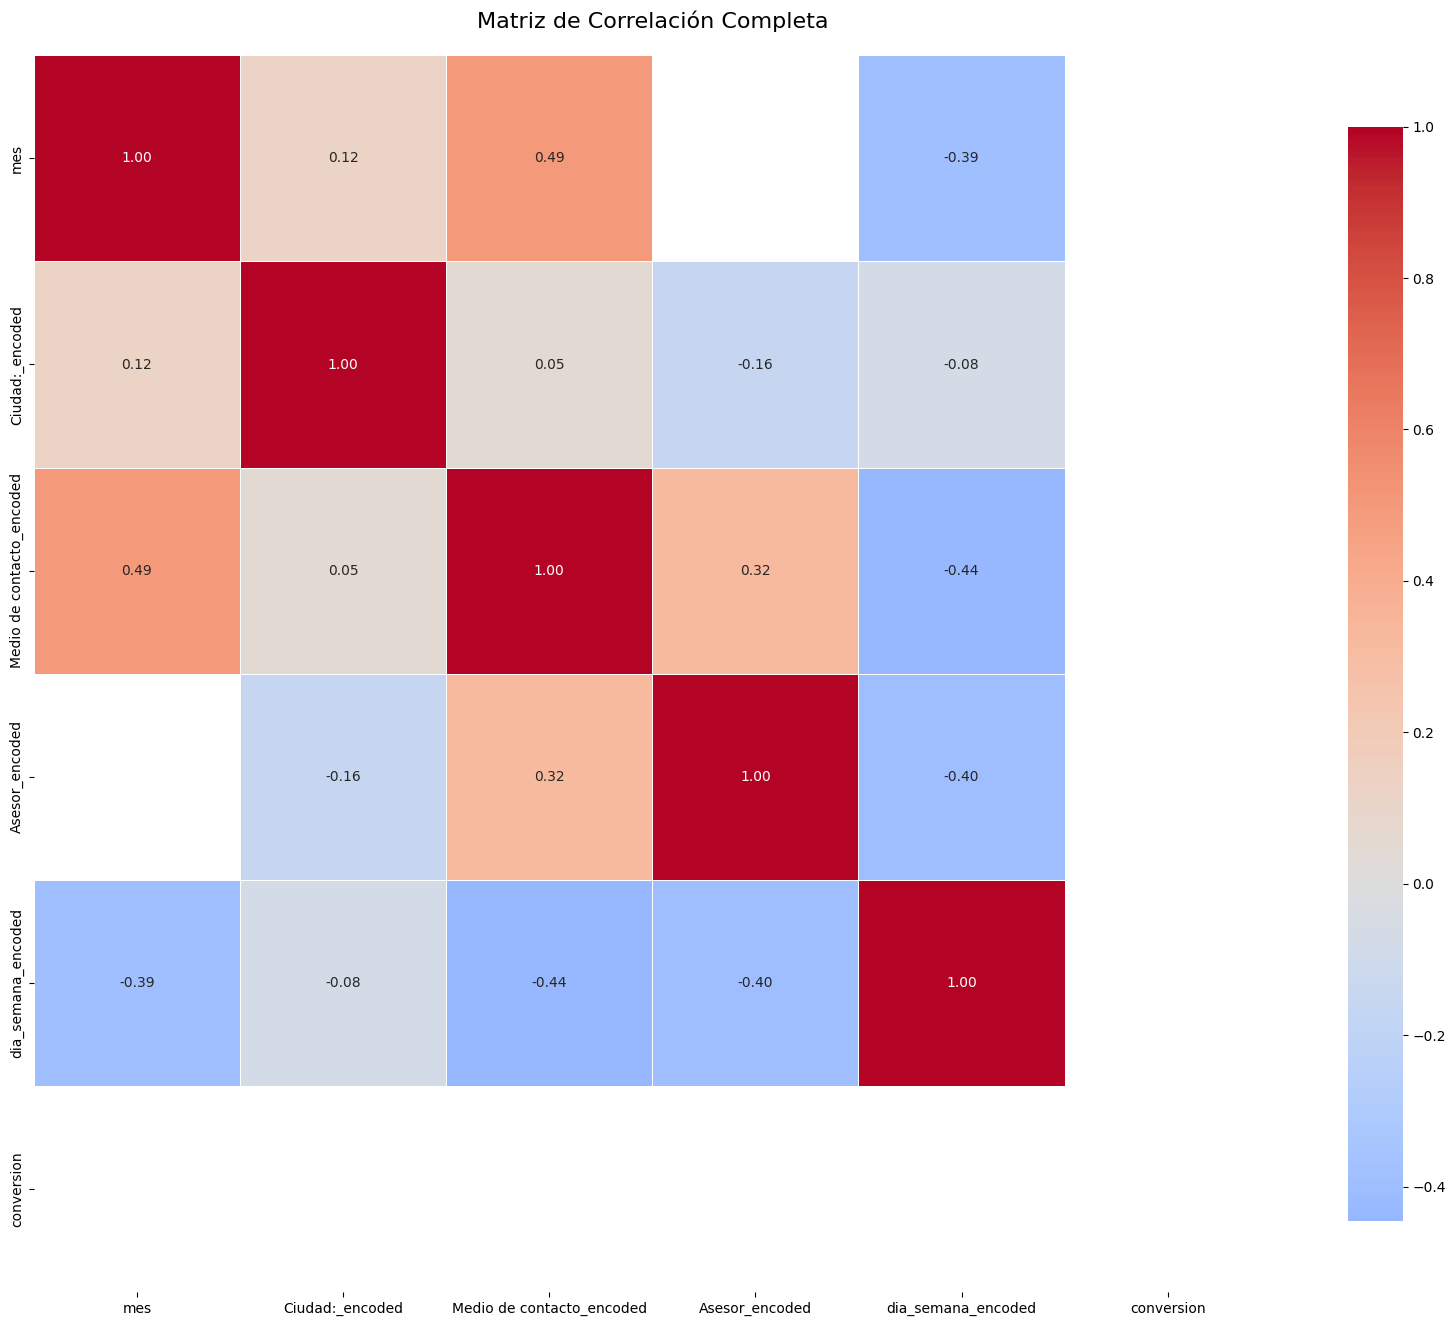

In [22]:
# ============================================================
# CALCULAR MATRIZ DE CORRELACIÓN
# ============================================================

correlation_matrix = df_numeric.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación Completa', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('matriz_correlacion_completa.png', dpi=300, bbox_inches='tight')
plt.show()